In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats, interpolate
import sympy

### Obtaining the data: 
Archives "Pk-fiducial-z_0_.dat" and "Pknw-fiducial-z_0_.dat" \
Columns: $k$ , $Pk/ s_8^2$ ,  $s_8$

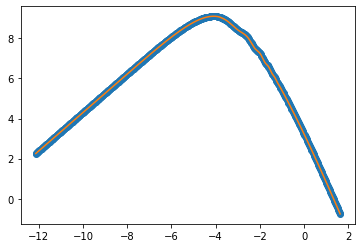

In [63]:
# f and D for each z_mean:
f = [0.8790616234808487, 0.9052940279841754, 0.9248305916607235, 0.942646864519483]
D = [0.6051299241324081, 0.5557769195555776, 0.5132266632166314, 0.46785418122063316]

# Based on table 3 of the page 14:
n = [6.86 * 10**(-4), 5.58 * 10**(-4), 4.21* 10**(-4), 2.61 * 10**(-4)]
V_s = [7.94, 9.15, 10.05, 16.22]
#galazy bias factor
b = [1.46, 1.61, 1.75, 1.9]

# Centered position of each bin
z_i = [1., 1.2, 1.4, 1.65]
z_min = [0.9, 1.1, 1.3, 1.5]
z_max = [1.1, 1.3, 1.5, 1.8]


Pk_00 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_00.dat")
Pk_01 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_01.dat")
Pk_02 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_02.dat")
Pk_03 = np.loadtxt("Pk-fiducial\Pk-fiducial-z_03.dat")

k_00 = Pk_00[:,0]
s8_00 = Pk_00[:,2]
P_dd00 = Pk_00[:,1] * (Pk_00[:,2]**2)

k_01 = Pk_01[:,0]
s8_01 = Pk_01[:,2]
P_dd01 = Pk_01[:,1] * (Pk_01[:,2]**2)

k_02 = Pk_02[:,0]
s8_02 = Pk_02[:,2]
P_dd02 = Pk_02[:,1] * (Pk_02[:,2]**2)

k_03 = Pk_03[:,0]
s8_03 = Pk_03[:,2]
P_dd03 = Pk_03[:,1] * (Pk_03[:,2]**2)

# Cubic spline interpolation
k = np.log(k_00)
y = np.log(P_dd00)
P_dd0 = interpolate.interp1d(k, y, kind='cubic')
k_00new = np.log(np.arange(k_00[0], k_00[-1], 0.0001))
y_00new = P_dd0(k_00new)
plt.plot(k, y, 'o', k_00new, y_00new, '-')
plt.show()

k = np.log(k_01)
y = np.log(P_dd01)
P_dd1 = interpolate.interp1d(k, y, kind='cubic')
k_01new = np.log(np.arange(k_01[0], k_01[-1], 0.0001))
y_01new = P_dd1(k_01new)
#plt.plot(k, y, 'o', k_01new, y_01new, '-')
#plt.show()

k = np.log(k_02)
y = np.log(P_dd02)
P_dd2 = interpolate.interp1d(k, y, kind='cubic')
k_02new = np.log(np.arange(k_02[0], k_02[-1], 0.0001))
y_02new = P_dd2(k_02new)
#plt.plot(k, y, 'o', k_02new, y_02new, '-')
#plt.show()

k = np.log(k_03)
y = np.log(P_dd03)
P_dd3 = interpolate.interp1d(k, y, kind='cubic')
k_03new = np.log(np.arange(k_03[0], k_03[-1], 0.0001))
y_03new = P_dd3(k_03new)
#plt.plot(k, y, 'o', k_03new, y_03new, '-')
#plt.show()


def P_dd(k, zi):
    if zi == z_i[0]:
        return P_dd0(np.log(k))
    elif zi == z_i[1]:
        return P_dd1(np.log(k))
    elif zi == z_i[2]:
        return P_dd2(np.log(k))
    else:
        return P_dd3(np.log(k))


[[1.37647758e-311 3.16202013e-322 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.57905628e-057 4.35292964e-061 1.11622857e-046]
 [3.21816038e-057 3.38209336e-061 8.25129520e-071 7.27486166e-043]]


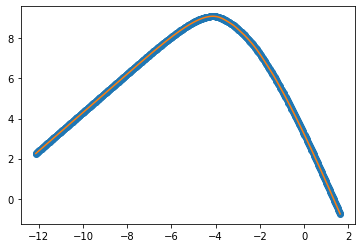

In [64]:
# For Pk_nw (no wiggled power spectrum)
Pk_nw_00 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_00.dat")
Pk_nw_01 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_01.dat")
Pk_nw_02 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_02.dat")
Pk_nw_03 = np.loadtxt("Pk-nw-fiducial\Pk-nw-fiducial-z_03.dat")

Pk_nw = [Pk_nw_00,Pk_nw_01, Pk_nw_02, Pk_nw_03 ]


a = np.empty((3,4))
for i in range(3):
   a[0,i] = Pk_nw[i][:,0]
   a[1,i] = Pk_nw[i][:,2]
   a[2,i] = Pk_nw[i][:,1] * (Pk_nw[i][:,2]**2)

print(a)
k_nw_00 = Pk_nw_00[:,0]
s8_nw_00 = Pk_nw_00[:,2]
P_dd_nw00 = Pk_nw_00[:,1] * (Pk_nw_00[:,2]**2)

k_nw_01 = Pk_nw_01[:,0]
s8_nw_01 = Pk_nw_01[:,2]
P_dd_nw01 = Pk_nw_01[:,1] * (Pk_nw_01[:,2]**2)

k_nw_02 = Pk_nw_02[:,0]
s8_nw_02 = Pk_nw_02[:,2]
P_dd_nw02 = Pk_nw_02[:,1] * (Pk_nw_02[:,2]**2)

k_nw_03 = Pk_nw_03[:,0]
s8_nw_03 = Pk_nw_03[:,2]
P_dd_nw03 = Pk_nw_03[:,1] * (Pk_nw_03[:,2]**2)

# Cubic spline interpolation
k = np.log(k_nw_00)
y = np.log(P_dd_nw00)
P_dd_nw0 = interpolate.interp1d(k, y, kind='cubic')
k_nw_00new = np.log(np.arange(k_nw_00[0], k_nw_00[-1], 0.0001))
y_nw_00new = P_dd_nw0(k_nw_00new)
plt.plot(k, y, 'o', k_nw_00new, y_nw_00new, '-')
plt.show()

k = np.log(k_nw_01)
y = np.log(P_dd_nw01)
P_dd_nw1 = interpolate.interp1d(k, y, kind='cubic')
k_nw_01new = np.log(np.arange(k_nw_01[0], k_nw_01[-1], 0.0001))
y_nw_01new = P_dd_nw1(k_nw_01new)
#plt.plot(k, y, 'o', k_nw_01new, y_nw_01new, '-')
#plt.show()

k = np.log(k_nw_02)
y = np.log(P_dd_nw02)
P_dd_nw2 = interpolate.interp1d(k, y, kind='cubic')
k_nw_02new = np.log(np.arange(k_nw_02[0], k_nw_02[-1], 0.0001))
y_nw_02new = P_dd_nw2(k_nw_02new)
#plt.plot(k, y, 'o', k_nw_02new, y_nw_02new, '-')
#plt.show()

k = np.log(k_nw_03)
y = np.log(P_dd_nw03)
P_dd_nw3 = interpolate.interp1d(k, y, kind='cubic')
k_nw_03new = np.log(np.arange(k_nw_03[0], k_nw_03[-1], 0.0001))
y_nw_03new = P_dd_nw3(k_nw_03new)
#plt.plot(k, y, 'o', k_nw_03new, y_nw_03new, '-')
#plt.show()


def P_nw(k, zi):
    if zi == z_i[0]:
        return P_dd_nw0(np.log(k))
    elif zi == z_i[1]:
        return P_dd_nw1(np.log(k))
    elif zi == z_i[2]:
        return P_dd_nw2(np.log(k))
    else:
        return P_dd_nw3(np.log(k))



Obteniendo los datos para las derivadas

In [65]:
# Derivative of h with negative step (mn)
Pk_h_mn = {}
for i in range(4):
    Pk_h_mn[i] = np.loadtxt("Pk-derivative\Pk_h_mn_eps_1p0E-2\Pk-h_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Derivative of ns with negative step (mn)
Pk_ns_mn = {}
for i in range(4):
    Pk_ns_mn[i] = np.loadtxt( "Pk-derivative\Pk_ns_mn_eps_1p0E-2\Pk-ns_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Derivative of wb with negative step (mn)
Pk_wb_mn = {}
for i in range(4):
    Pk_wb_mn[i] = np.loadtxt( "Pk-derivative\Pk_wb_mn_eps_1p0E-2\Pk-wb_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Derivative of wm with negative step (mn)
Pk_wm_mn = {}
for i in range(4):
    Pk_wm_mn[i] = np.loadtxt( "Pk-derivative\Pk_wm_mn_eps_1p0E-2\Pk-wm_mn_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")


param = ['h', 'ns', 'wb', 'wm']
for j in param:
    for i in range(4):
        exec(f'k_{j}_mn_0{i} = Pk_{j}_mn[{i}][:,0]')
        exec(f's8_{j}_mn_0{i} = Pk_{j}_mn[{i}][:,2]')
        exec(f'P_dd_{j}_mn_0{i} = Pk_{j}_mn[{i}][:,1] * (Pk_{j}_mn[{i}][:,2]**2)')

# Cubic spline interpolation
for j in param:
    for i in range(4):
        exec(f"k = np.log(Pk_{j}_mn[{i}][:,0])")
        exec(f"y = np.log(P_dd_{j}_mn_0{i})")
        exec(f"P_dd_{j}_mn_{i} = interpolate.interp1d(k, y, kind='cubic')")

        exec(f"def P_dd_{j}_mn(k, zi): 
             if zi == z_i[0]:
                return P_dd_{j}_mn_0(np.log(k))
            elif zi == z_i[1]:
                return P_dd_{j}_mn_1(np.log(k))
            elif zi == z_i[2]:
                return P_dd_{j}_mn_2(np.log(k))
            else:
                return P_dd_{j}_mn_3(np.log(k))")

print(P_dd_h_mn_0(np.log(k)))


# Derivative of h with positive step (pl)
Pk_h_pl = {}
for i in range(4):
    Pk_h_pl[i] = np.loadtxt("Pk-derivative\Pk_h_pl_eps_1p0E-2\Pk-h_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Derivative of ns with positive step (pl)
Pk_ns_pl = {}
for i in range(4):
    Pk_ns_pl[i] = np.loadtxt( "Pk-derivative\Pk_ns_pl_eps_1p0E-2\Pk-ns_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Derivative of wb with positive step (pl)
Pk_wb_pl = {}
for i in range(4):
    Pk_wb_pl[i] = np.loadtxt( "Pk-derivative\Pk_wb_pl_eps_1p0E-2\Pk-wb_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

# Derivative of wm with positive step (pl)
Pk_wm_pl = {}
for i in range(4):
    Pk_wm_pl[i] = np.loadtxt( "Pk-derivative\Pk_wm_pl_eps_1p0E-2\Pk-wm_pl_eps_1p0E-2-z_" + "{:02d}".format(i) + ".dat")

param = ['h', 'ns', 'wb', 'wm']
for j in param:
    for i in range(4):
        exec(f'k_{j}_mn_0{i} = Pk_{j}_mn[{i}][:,0]')
        exec(f's8_{j}_mn_0{i} = Pk_{j}_mn[{i}][:,2]')
        exec(f'P_dd_{j}_mn_0{i} = Pk_{j}_mn[{i}][:,1] * (Pk_{j}_mn[{i}][:,2]**2)')

# Cubic spline interpolation
for j in param:
    for i in range(4):
        exec(f"k = np.log(Pk_{j}_mn[{i}][:,0])")
        exec(f"y = np.log(P_dd_{j}_mn_0{i})")
        exec(f"P_dd_{j}_mn_{i} = interpolate.interp1d(k, y, kind='cubic')")

        exec(f"def P_dd_{j}_mn(k, zi):
            if zi == z_i[0]:
                return P_dd_{j}_mn_0(np.log(k))
            elif zi == z_i[1]:
                return P_dd_{j}_mn_1(np.log(k))
            elif zi == z_i[2]:
                return P_dd_{j}_mn_2(np.log(k))
            else:
                return P_dd_{j}_mn_3(np.log(k))")



SyntaxError: EOL while scanning string literal (<ipython-input-65-4ce62027d526>, line 36)

In [ ]:
# Antiguo:

# Derivative of h with negative step (mn)
Pk_h_mn_00 = np.loadtxt("Pk_h_mn_eps_1p0E-2\Pk-h_mn_eps_1p0E-2-z_00.dat")
Pk_h_mn_01 = np.loadtxt("Pk_h_mn_eps_1p0E-2\Pk-h_mn_eps_1p0E-2-z_01.dat")
Pk_h_mn_02 = np.loadtxt("Pk_h_mn_eps_1p0E-2\Pk-h_mn_eps_1p0E-2-z_02.dat")
Pk_h_mn_03 = np.loadtxt("Pk_h_mn_eps_1p0E-2\Pk-h_mn_eps_1p0E-2-z_03.dat")

param = ['h', 'ns', 'wb', 'wm']
for j in param:
    for i in range(4):
        exec(f's8_'+j+'_mn_0{i} = Pk_'+j+'_mn_0{i}[:,2]')
        exec(f'P_dd_'+j+'_mn_0{i} = Pk_'+j+'_mn_0{i}[:,1] * (Pk_'+j+'_mn_0{i}[:,2]**2)')

# Cubic spline interpolation
k = np.log(k_nw_00)
y = np.log(P_dd_nw00)
P_dd_nw0 = interpolate.interp1d(k, y, kind='cubic')
k_nw_00new = np.log(np.arange(k_nw_00[0], k_nw_00[-1], 0.0001))
y_nw_00new = P_dd_nw0(k_nw_00new)
plt.plot(k, y, 'o', k_nw_00new, y_nw_00new, '-')
plt.show()

k = np.log(k_nw_01)
y = np.log(P_dd_nw01)
P_dd_nw1 = interpolate.interp1d(k, y, kind='cubic')
k_nw_01new = np.log(np.arange(k_nw_01[0], k_nw_01[-1], 0.0001))
y_nw_01new = P_dd_nw1(k_nw_01new)
#plt.plot(k, y, 'o', k_nw_01new, y_nw_01new, '-')
#plt.show()

k = np.log(k_nw_02)
y = np.log(P_dd_nw02)
P_dd_nw2 = interpolate.interp1d(k, y, kind='cubic')
k_nw_02new = np.log(np.arange(k_nw_02[0], k_nw_02[-1], 0.0001))
y_nw_02new = P_dd_nw2(k_nw_02new)
#plt.plot(k, y, 'o', k_nw_02new, y_nw_02new, '-')
#plt.show()

k = np.log(k_nw_03)
y = np.log(P_dd_nw03)
P_dd_nw3 = interpolate.interp1d(k, y, kind='cubic')
k_nw_03new = np.log(np.arange(k_nw_03[0], k_nw_03[-1], 0.0001))
y_nw_03new = P_dd_nw3(k_nw_03new)

def P_dd_h_mn(k, zi):
    if zi == z_i[0]:
        ind_k = k_00.index(k)
        return P_dd_h_mn_00[ind_k]
    elif zi == z_i[1]:
        ind_k = k_01.index(k)
        return P_dd_h_mn_01[ind_k]
    elif zi == z_i[2]:
        ind_k = k_02.index(k)
        return P_dd_h_mn_02[ind_k]
    else:
        ind_k = k_03.index(k)
        return P_dd_h_mn_03[ind_k]

# Derivative of h with positive step (pl)
Pk_h_pl_00 = np.loadtxt("Pk_h_pl_eps_1p0E-2\Pk-h_pl_eps_1p0E-2-z_00.dat")
Pk_h_pl_01 = np.loadtxt("Pk_h_pl_eps_1p0E-2\Pk-h_pl_eps_1p0E-2-z_01.dat")
Pk_h_pl_02 = np.loadtxt("Pk_h_pl_eps_1p0E-2\Pk-h_pl_eps_1p0E-2-z_02.dat")
Pk_h_pl_03 = np.loadtxt("Pk_h_pl_eps_1p0E-2\Pk-h_pl_eps_1p0E-2-z_03.dat")

s8_h_pl_00 = Pk_h_pl_00[:,2]
P_dd_h_pl_00 = Pk_h_pl_00[:,1] * (Pk_h_pl_00[:,2]**2)

s8_h_pl_01 = Pk_h_pl_01[:,2]
P_dd_h_pl_01= Pk_h_pl_01[:,1] * (Pk_h_pl_01[:,2]**2)

s8_h_pl_02 = Pk_h_pl_02[:,2]
P_dd_h_pl_02 = Pk_h_pl_02[:,1] * (Pk_h_pl_02[:,2]**2)

s8_h_pl_03 = Pk_h_pl_03[:,2]
P_dd_h_pl_03 = Pk_h_pl_03[:,1] * (Pk_h_pl_03[:,2]**2)

def P_dd_h_pl(k, zi):
    if zi == z_i[0]:
        ind_k = k_00.index(k)
        return Pk_h_pl_00[ind_k]
    elif zi == z_i[1]:
        ind_k = k_01.index(k)
        return Pk_h_pl_01[ind_k]
    elif zi == z_i[2]:
        ind_k = k_02.index(k)
        return Pk_h_pl_02[ind_k]
    else:
        ind_k = k_03.index(k)
        return Pk_h_pl_03[ind_k]

# ------
    
# Derivative of ns with negative step (mn)
Pk_ns_mn_00 = np.loadtxt("Pk_ns_mn_eps_1p0E-2\Pk-ns_mn_eps_1p0E-2-z_00.dat")
Pk_ns_mn_01 = np.loadtxt("Pk_ns_mn_eps_1p0E-2\Pk-ns_mn_eps_1p0E-2-z_01.dat")
Pk_ns_mn_02 = np.loadtxt("Pk_ns_mn_eps_1p0E-2\Pk-ns_mn_eps_1p0E-2-z_02.dat")
Pk_ns_mn_03 = np.loadtxt("Pk_ns_mn_eps_1p0E-2\Pk-ns_mn_eps_1p0E-2-z_03.dat")

s8_ns_mn_00 = Pk_ns_mn_00[:,2]
P_dd_ns_mn_00 = Pk_h_mn_00[:,1] * (Pk_ns_mn_00[:,2]**2)

s8_ns_mn_01 = Pk_ns_mn_01[:,2]
P_dd_ns_mn_01= Pk_ns_mn_01[:,1] * (Pk_ns_mn_01[:,2]**2)

s8_ns_mn_02 = Pk_ns_mn_02[:,2]
P_dd_ns_mn_02 = Pk_ns_mn_02[:,1] * (Pk_ns_mn_02[:,2]**2)

s8_ns_mn_03 = Pk_ns_mn_03[:,2]
P_dd_ns_mn_03 = Pk_ns_mn_03[:,1] * (Pk_ns_mn_03[:,2]**2)

def P_dd_ns_mn(k, zi):
    if zi == z_i[0]:
        ind_k = k_00.index(k)
        return P_dd_ns_mn_00[ind_k]
    elif zi == z_i[1]:
        ind_k = k_01.index(k)
        return P_dd_ns_mn_01[ind_k]
    elif zi == z_i[2]:
        ind_k = k_02.index(k)
        return P_dd_ns_mn_02[ind_k]
    else:
        ind_k = k_03.index(k)
        return P_dd_ns_mn_03[ind_k]

# Derivative of ns with positive step (pl)
Pk_ns_pl_00 = np.loadtxt("Pk_ns_pl_eps_1p0E-2\Pk-ns_pl_eps_1p0E-2-z_00.dat")
Pk_ns_pl_01 = np.loadtxt("Pk_ns_pl_eps_1p0E-2\Pk-ns_pl_eps_1p0E-2-z_01.dat")
Pk_ns_pl_02 = np.loadtxt("Pk_ns_pl_eps_1p0E-2\Pk-ns_pl_eps_1p0E-2-z_02.dat")
Pk_ns_pl_03 = np.loadtxt("Pk_ns_pl_eps_1p0E-2\Pk-ns_pl_eps_1p0E-2-z_03.dat")

s8_ns_pl_00 = Pk_ns_pl_00[:,2]
P_dd_ns_pl_00 = Pk_ns_pl_00[:,1] * (Pk_ns_pl_00[:,2]**2)

s8_ns_pl_01 = Pk_ns_pl_01[:,2]
P_dd_ns_pl_01= Pk_ns_pl_01[:,1] * (Pk_ns_pl_01[:,2]**2)

s8_ns_pl_02 = Pk_ns_pl_02[:,2]
P_dd_ns_pl_02 = Pk_ns_pl_02[:,1] * (Pk_ns_pl_02[:,2]**2)

s8_ns_pl_03 = Pk_ns_pl_03[:,2]
P_dd_ns_pl_03 = Pk_ns_pl_03[:,1] * (Pk_ns_pl_03[:,2]**2)

def P_dd_ns_pl(k, zi):
    if zi == z_i[0]:
        ind_k = k_00.index(k)
        return Pk_ns_pl_00[ind_k]
    elif zi == z_i[1]:
        ind_k = k_01.index(k)
        return Pk_ns_pl_01[ind_k]
    elif zi == z_i[2]:
        ind_k = k_02.index(k)
        return Pk_ns_pl_02[ind_k]
    else:
        ind_k = k_03.index(k)
        return Pk_ns_pl_03[ind_k]
# --------

# Derivative of wb with negative step (mn)
Pk_wb_mn_00 = np.loadtxt("Pk_wb_mn_eps_1p0E-2\Pk-wb_mn_eps_1p0E-2-z_00.dat")
Pk_wb_mn_01 = np.loadtxt("Pk_wb_mn_eps_1p0E-2\Pk-wb_mn_eps_1p0E-2-z_01.dat")
Pk_wb_mn_02 = np.loadtxt("Pk_wb_mn_eps_1p0E-2\Pk-wb_mn_eps_1p0E-2-z_02.dat")
Pk_wb_mn_03 = np.loadtxt("Pk_wb_mn_eps_1p0E-2\Pk-wb_mn_eps_1p0E-2-z_03.dat")

s8_wb_mn_00 = Pk_wb_mn_00[:,2]
P_dd_wb_mn_00 = Pk_wb_mn_00[:,1] * (Pk_wb_mn_00[:,2]**2)

s8_wb_mn_01 = Pk_wb_mn_01[:,2]
P_dd_wb_mn_01= Pk_wb_mn_01[:,1] * (Pk_wb_mn_01[:,2]**2)

s8_wb_mn_02 = Pk_wb_mn_02[:,2]
P_dd_wb_mn_02 = Pk_wb_mn_02[:,1] * (Pk_wb_mn_02[:,2]**2)

s8_wb_mn_03 = Pk_wb_mn_03[:,2]
P_dd_wb_mn_03 = Pk_wb_mn_03[:,1] * (Pk_wb_mn_03[:,2]**2)

def P_dd_wb_mn(k, zi):
    if zi == z_i[0]:
        ind_k = k_00.index(k)
        return P_dd_wb_mn_00[ind_k]
    elif zi == z_i[1]:
        ind_k = k_01.index(k)
        return P_dd_wb_mn_01[ind_k]
    elif zi == z_i[2]:
        ind_k = k_02.index(k)
        return P_dd_wb_mn_02[ind_k]
    else:
        ind_k = k_03.index(k)
        return P_dd_wb_mn_03[ind_k]

# Derivative of wb with positive step (pl)
Pk_wb_pl_00 = np.loadtxt("Pk_wb_pl_eps_1p0E-2\Pk-wb_pl_eps_1p0E-2-z_00.dat")
Pk_wb_pl_01 = np.loadtxt("Pk_wb_pl_eps_1p0E-2\Pk-wb_pl_eps_1p0E-2-z_01.dat")
Pk_wb_pl_02 = np.loadtxt("Pk_wb_pl_eps_1p0E-2\Pk-wb_pl_eps_1p0E-2-z_02.dat")
Pk_wb_pl_03 = np.loadtxt("Pk_wb_pl_eps_1p0E-2\Pk-wb_pl_eps_1p0E-2-z_03.dat")

s8_wb_pl_00 = Pk_wb_pl_00[:,2]
P_dd_wb_pl_00 = Pk_wb_pl_00[:,1] * (Pk_wb_pl_00[:,2]**2)

s8_wb_pl_01 = Pk_wb_pl_01[:,2]
P_dd_wb_pl_01= Pk_wb_pl_01[:,1] * (Pk_wb_pl_01[:,2]**2)

s8_wb_pl_02 = Pk_wb_pl_02[:,2]
P_dd_wb_pl_02 = Pk_wb_pl_02[:,1] * (Pk_wb_pl_02[:,2]**2)

s8_wb_pl_03 = Pk_wb_pl_03[:,2]
P_dd_wb_pl_03 = Pk_wb_pl_03[:,1] * (Pk_wb_pl_03[:,2]**2)

def P_dd_wb_pl(k, zi):
    if zi == z_i[0]:
        ind_k = k_00.index(k)
        return Pk_wb_pl_00[ind_k]
    elif zi == z_i[1]:
        ind_k = k_01.index(k)
        return Pk_wb_pl_01[ind_k]
    elif zi == z_i[2]:
        ind_k = k_02.index(k)
        return Pk_wb_pl_02[ind_k]
    else:
        ind_k = k_03.index(k)
        return Pk_wb_pl_03[ind_k]
#-----

# Derivative of wm with negative step (mn)
Pk_wm_mn_00 = np.loadtxt("Pk_wm_mn_eps_1p0E-2\Pk-wm_mn_eps_1p0E-2-z_00.dat")
Pk_wm_mn_01 = np.loadtxt("Pk_wm_mn_eps_1p0E-2\Pk-wm_mn_eps_1p0E-2-z_01.dat")
Pk_wm_mn_02 = np.loadtxt("Pk_wm_mn_eps_1p0E-2\Pk-wm_mn_eps_1p0E-2-z_02.dat")
Pk_wm_mn_03 = np.loadtxt("Pk_wm_mn_eps_1p0E-2\Pk-wm_mn_eps_1p0E-2-z_03.dat")

s8_wm_mn_00 = Pk_wm_mn_00[:,2]
P_dd_wm_mn_00 = Pk_wm_mn_00[:,1] * (Pk_wm_mn_00[:,2]**2)

s8_wm_mn_01 = Pk_wm_mn_01[:,2]
P_dd_wm_mn_01= Pk_wm_mn_01[:,1] * (Pk_wm_mn_01[:,2]**2)

s8_wm_mn_02 = Pk_wm_mn_02[:,2]
P_dd_wm_mn_02 = Pk_wm_mn_02[:,1] * (Pk_wm_mn_02[:,2]**2)

s8_wm_mn_03 = Pk_wm_mn_03[:,2]
P_dd_wm_mn_03 = Pk_wm_mn_03[:,1] * (Pk_wm_mn_03[:,2]**2)

def P_dd_wm_mn(k, zi):
    if zi == z_i[0]:
        ind_k = k_00.index(k)
        return P_dd_wm_mn_00[ind_k]
    elif zi == z_i[1]:
        ind_k = k_01.index(k)
        return P_dd_wm_mn_01[ind_k]
    elif zi == z_i[2]:
        ind_k = k_02.index(k)
        return P_dd_wm_mn_02[ind_k]
    else:
        ind_k = k_03.index(k)
        return P_dd_wm_mn_03[ind_k]


# Derivative of wm with positive step (pl)
Pk_wm_pl_00 = np.loadtxt("Pk_wm_pl_eps_1p0E-2\Pk-wm_pl_eps_1p0E-2-z_00.dat")
Pk_wm_pl_01 = np.loadtxt("Pk_wm_pl_eps_1p0E-2\Pk-wm_pl_eps_1p0E-2-z_01.dat")
Pk_wm_pl_02 = np.loadtxt("Pk_wm_pl_eps_1p0E-2\Pk-wm_pl_eps_1p0E-2-z_02.dat")
Pk_wm_pl_03 = np.loadtxt("Pk_wm_pl_eps_1p0E-2\Pk-wm_pl_eps_1p0E-2-z_03.dat")

s8_wm_pl_00 = Pk_wm_pl_00[:,2]
P_dd_wm_pl_00 = Pk_wm_pl_00[:,1] * (Pk_wm_pl_00[:,2]**2)

s8_wm_pl_01 = Pk_wm_pl_01[:,2]
P_dd_wm_pl_01= Pk_wm_pl_01[:,1] * (Pk_wm_pl_01[:,2]**2)

s8_wm_pl_02 = Pk_wm_pl_02[:,2]
P_dd_wm_pl_02 = Pk_wm_pl_02[:,1] * (Pk_wm_pl_02[:,2]**2)

s8_wm_pl_03 = Pk_wm_pl_03[:,2]
P_dd_wm_pl_03 = Pk_wm_pl_03[:,1] * (Pk_wm_pl_03[:,2]**2)

def P_dd_wm_pl(k, zi):
    if zi == z_i[0]:
        ind_k = k_00.index(k)
        return Pk_wm_pl_00[ind_k]
    elif zi == z_i[1]:
        ind_k = k_01.index(k)
        return Pk_wm_pl_01[ind_k]
    elif zi == z_i[2]:
        ind_k = k_02.index(k)
        return Pk_wm_pl_02[ind_k]
    else:
        ind_k = k_03.index(k)
        return Pk_wm_pl_03[ind_k]

NameError: name 'np' is not defined

Parámetros a encontrar:
$D_A(z_i)$, $H(z_i)$, $f\sigma_8(z_i)$, $b\sigma_8$ , $P_s(z_i)$, $\omega_{b,0}$, $h$, $\omega_{m,0}$, $n_s$, $\sigma_v (z_{mean})$ y $\sigma_p (z_{mean})$


In [ ]:
#Fiducial parameters
Om_b0 = 0.022445
h = 0.67
H0 = 100 * h

Om_m0 = 0.143648
n_s = 0.96

c = 300.000

'''
Qué es As10^9?
# Donde se usa? y por qué se especifica el A_s^9
'''
A_s9 = 2.12605
# Reference amplitud As
A_s = 2.1260500000000005e-9
s8_ref = 0.815583

''' 
Cuáles son los non-pyhsical base and physical? y xq la suma no da Om_m?
'''
# Corresponding non-physical base parameters: {Omegab,  Omegac, h, 10^9 As} :> {0.05000000000000001, 0.2671256676696824, 0.67, 2.1260500000000007}
Om_b_np= 0.05000000000000001
Om_c_np = 0.2671256676696824
A_s9 = 2.1260500000000007
# Corresponding physical base parameters: {omegab,  omegac, h, 10^9 As} :> {0.022445000000000007, 0.11991271221692044, 0.67, 2.1260500000000007}
Om_b_p= 0.022445000000000007
Om_c_p = 0.11991271221692044

# Halofit version in CAMB: 4
# Maximum k value in CAMB (h/Mpc): 5
# Numeric CAMB parameters : {AccuracyBoost -> 2, TransferHighPrecision -> True, TransferKperLogInt -> 50}
# Constant Neutrino CAMB parameters : {OmegaNu -> 0.00143717, MasslessNeutrinos -> 2.046, MassiveNeutrinos -> 1, NuMassFractions -> {1}}
Om_nu = 0.00143717

# Defining Om_c
Om_c0 = Om_m0 - Om_b0 - Om_nu

print('Om_m:', Om_m0)
print('physical Om_m:', Om_b_p + Om_c_p + Om_nu)
print('non-physical Om_m:',Om_b_np + Om_c_np + Om_nu)

# np.sqrt(Om_m0 + Om_DE0 + Om_k0) = 1
Om_DE0 = - Om_m0  

m_nu = 0.06
w_0 = -1
w_a = 0

A_surv = 15000
s_z = 0.0001 #Spectroscopic redshift error

P_s = 0

# Defining mu
u = np.linspace(-1, 1, num= len(k_00))

Om_m: 0.143648
physical Om_m: 0.14379488221692044
non-physical Om_m: 0.31856283766968235


In [ ]:
# s8 es 1 para cada z

s8 = np.zeros_like(z_i)
bs8 = np.zeros_like(z_i)
fs8 = np.zeros_like(z_i)
for i in range(0, 4):
        if i == 0:
                s8[i]= s8_00[0]
                bs8[i] = b[i] * s8_00[0]
                fs8[i] = f[i] * s8_00[0]
        elif i == 1:
                s8[i]= s8_01[0]
                bs8[i] = b[i] * s8_01[0]
                fs8[i] = f[i] * s8_01[0]
        elif i == 2:
                s8[i]= s8_02[0]
                bs8[i] = b[i] * s8_02[0]
                fs8[i] = f[i] * s8_02[0]
        else:
                s8[i]= s8_03[0]
                bs8[i] = b[i] * s8_03[0]
                fs8[i] = f[i] * s8_03[0]
# print(s8)

In [ ]:
def E(z):
    return np.sqrt((Om_m0*(1+z)**(3)) + Om_DE0)

def H_ref(z):
    return H0 * E(z)

def r(z):
    a = 1/E(z)
    return (c/H0) * np.cumsum(a, dtype=float)  

def D_A_ref(z):
    return (1+z)**(-1) * r(z)


In [ ]:
# Comoving distance error sr

def F_z(k_ref,u_ref,z):
  return np.exp(-((k_ref* u_ref*c *(1+z)* s_z)/H_ref(z))**2)

def qpar(z, H = None):
  H_value = H_ref(z) if H is None else H
  return H_ref(z)/H_value

def qper(z, D_A = None):
  D_A_value = D_A_ref(z) if D_A is None else D_A
  return D_A_value/ D_A_ref(z)


# To convert the known reference k_ref and mu_ref to the unknown, true k and mu
def k(z, k_ref, u_ref, H = None, D_A = None):
  qper = qper(z, D_A = D_A)
  qpar = qpar(z, H = H)
  return (k_ref /qper)* (1 + u_ref**2 * ((qper**2/qpar**2) -1))**(1/2)

def u(z, u_ref, H = None, D_A = None):
  qper = qper(z, D_A = D_A)
  qpar = qpar(z, H = H)
  return u_ref * (qper/qpar) * (1 + u_ref**2 * ((qper**2/qpar**2) -1))**(-1/2)

# Non-linear damping factor of the BAO signal.
def g_u(u, zi):
  bin = z_i.index(zi)
  return sv[bin]**2 *(1- u**2 + (u**2)*(1+ f[bin])**2)

def P_dw(k, u, z, paso = None, var = None):
  if paso == None:
    return P_dd(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))
  
  elif paso == 'pl':
    if var == 'h':
      return P_dd_h_pl(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw_h_pl(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))
    if var == 'ns':
      return P_dd_ns_pl(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw_ns_pl(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))
    if var == 'wb':
      return P_dd_wb_pl(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw_wb_pl(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))
    if var == 'wm':
      return P_dd_wm_pl(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw_wm_pl(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))
    
  else:
    if var == 'h':
      return P_dd_h_mn(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw_h_mn(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))
    if var == 'ns':
      return P_dd_ns_mn(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw_ns_mn(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))
    if var == 'wb':
      return P_dd_wb_mn(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw_wb_mn(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))
    if var == 'wm':
      return P_dd_wm_mn(k, u, z)* np.exp(-g_u(u,z)*k**2) + P_nw_wm_mn(k,u,z)* (1- np.exp(-g_u(u,z)*k**2))

# In practice:
# sv(z) controls the strength of the non-linear damping of the BAO signal in all directions.
def sv_2_(zi):
  if zi == z_i[0]:
     I = np.trapz(P_dd0(k_00new), k_00new)
  elif zi == z_i[1]:
     I = np.trapz(P_dd1(k_01new), k_01new)
  elif zi == z_i[2]:
     I = np.trapz(P_dd2(k_02new), k_02new)
  else:
     I = np.trapz(P_dd3(k_03new), k_03new)
  return (1/(6* (np.pi**2)))* I

def sp_2_(zi):
  return sv_2_(zi)

def sv_(zi):
  return np.sqrt(sv_2_(zi))

def sp_(zi):
  return np.sqrt(sp_2_(zi)) 

sv = [sv_(z_i[0]), sv_(z_i[1]), sv_(z_i[2]), sv_(z_i[3])]
sp = [sp_(z_i[0]), sp_(z_i[1]), sp_(z_i[2]), sp_(z_i[3])]
#print(sp)


In [ ]:
# Full non-linear model
def P_obs(k_ref, u_ref, zi, bs8=None, fs8=None, f= None , sp=None, s8= None, H= None, D_A = None):
  bin = z_i.index(zi)
  bs8_value = bs8[bin] if bs8 is None else bs8
  fs8_value = fs8[bin] if fs8 is None else fs8
  f_value = f[bin] if f is None else f
  sp_value = sp[bin] if sp is None else sp
  s8_value = s8[bin] if s8 is None else s8
  
  H_value = None if H is None else H
  D_A_value = None if D_A is None else D_A
  
  k_eval = k(k_ref, u_ref, H = H_value, D_A = D_A_value)
  u_eval = u(k_ref, u_ref, H = H_value, D_A = D_A_value)

  # Cómo saco la dependencia de H para H_value = None
  return (1/(qpar(zi, H= H_value)**2 * qper(zi, D_A = D_A_value)))*((bs8_value + fs8_value*u_eval**2)**2/(1+(f_value*k_eval*u_eval*sp_value)**2)) * (P_dw(k_eval,u_eval,zi)/s8_value**2)* F_z(k_eval,u_eval,zi) + P_s


def V_eff(zi, k, u):
  bin = z_i.index(zi)
  return V_s[bin] * (n[bin])*P_obs(k,u, zi)/(n[bin]*P_obs(k,u, zi) + 1)**2

In [ ]:
# epsilon varía entre los 0.0001 y 0.01
def derivada_ln_P_obs(k, u, z, a, eps =1e-4):
    #h: Tamaño del paso (opcional, por defecto 1e-5)
    bin = z_i.index(z)
    if a == 'P_s':
      ln_P_obs = np.log(P_obs)
      derivada = 1/ ln_P_obs(k, u, z)

# que pasa con las derivadas con las otras componentes?

    # if are shape parameters w_b0 , h, w_m0 , n_s
    elif a == 'w_b0' or a== 'h' or a == 'w_m0' or a == 'n_s':
      # str to function
      a= globals().get(a)
      derivada = ( np.log(P_dw(k,z, a = a[bin]*(1+ eps))/s8[bin]**2)- np.log(P_dw(k,z, a = a[bin] *(1-eps))/s8[bin]**2) )/ (2 * eps* a)

    # if are non-linear parameters sv y sp
    #three-point stencil derivative of f with respect to x at x0
    elif a == 'sv':
      derivada = (np.log(P_dw(k, u, z, sv = sv[bin]*(1+ eps))/ s8[bin]**2)- np.log(P_dw(k, u, z, sv = sv[bin]*(1 - eps))/ s8[bin]**2)) / (2 * eps * np.log(P_dw(k, u, z, sv = sv)/ s8[bin]**2))

    elif a == 'sp':
      derivada = (np.log(1/ (1+(f[bin]*k*u*sp[bin]*(1+ eps))**2))- np.log(1/ (1+(f[bin]*k*u*sp[bin]*(1- eps))**2))) / (2 * eps * np.log(1/ (1+(f[bin]*k*u*sp[bin])**2)))

    # if parameters are fs8 and bs8
    elif a == 'fs8':
      derivada = (np.log(P_obs(k,u,z, fs8 = fs8[bin]**(1 + eps))) - np.log(P_obs(k,u,z, fs8 = fs8[bin]**(1 - eps)))) / (2* eps * np.log(fs8[bin]))

    elif a == 'bs8':
      derivada = (np.log(P_obs(k,u,z, bs8 = bs8[bin]**(1 + eps))) - np.log(P_obs(k,u, z, bs8 = bs8[bin]**(1 - eps)))) / (2* eps * np.log(bs8[bin]))


    elif a == 'H':
      derivada = 8* (np.log(P_obs(k,u,z, H= H_ref(z)**(1+ eps)))- np.log(P_obs(k, u, z,H= H_ref(z)**(1- eps))))/(12* eps * np.log(H_ref(z))) - (np.log(P_obs(k,u,z, H= H_ref(z)**(1+ 2*eps)))- np.log(P_obs(k, u, z, H= H_ref(z)**(1 - 2*eps))))/(12* eps * np.log(H_ref(z)))
    elif a == 'D_A':
      derivada = 8* (np.log(P_obs(k,u,z, D_A = D_A_ref(z)**(1+ eps)))- np.log(P_obs(k, u, z, D_A = D_A_ref(z)**(1- eps))))/(12* eps * np.log(D_A_ref(z))) - (np.log(P_obs(k,u,z, D_A = D_A_ref(z)**(1+ 2*eps)))- np.log(P_obs(k, u, z, D_A = D_A_ref(z)**(1 - 2*eps))))/(12* eps * np.log(D_A_ref(z)))

    return derivada



In [ ]:
'''
Se debe integrar numéricamente con trapecios o simpson?
Lo hice con trapecios, está bien?
'''
#romber
#cumsum

k_min = 0
k_max = 1
#ver parámetros reales

a = 'bs8'
b = 'f'

#definimos los parámetros con los cuales derivar
k = np.linspace(k_min, k_max, 100)
u = np.linspace(-1, 1, 100)
def ec1(k, u, zi, a, b):
  return k**2 * derivada_ln_P_obs(k, u, zi, a) *derivada_ln_P_obs(k, u, zi, b)* V_eff(zi, k, u)

# Realizar la integración utilizando la regla del trapecio
ec2 = np.trapz(ec1, k)

# Segunda integral
ec3 = np.trapz(ec2, u)

print("El resultado de la integral es:", ec3)

IndexError: list assignment index out of range

In [ ]:
def D_A_ref(z):
    if Om_k0 < 0:
        return (1+z)**(-1) * (c/H0) * (1/ np.sqrt(-Om_k0))* np.sin(np.sqrt(-Om_k0) * (H0/c) * r(z))
    elif Om_k0 == 0:
        return (1+z)**(-1) * r(z)
    else:
        return (1+z)**(-1) * (c/H0) * (1/ np.sqrt(Om_k0))* np.sinh(np.sqrt(Om_k0) * (H0/c) * r(z))